# Model meteorite anomalies from Monash s-process yields
In this notebook we can compare how internal normalisation alters the trendlines for a set of s-process yields from the Monash group.

In [48]:
# Copyright (c) 2022 Mattias Ek
# https://github.com/mattias-ek/fruity-norm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import isopy
import itertools

---

This section loads the monash models and defines the functions we use in the next section

In [46]:
# The solar abundance from Lodders 2009
solar = isopy.refval.isotope.initial_solar_system_abundance_L09
solar_si = np.sum(solar.to_array(element_symbol='si'), axis=None)

# Get model data
model_data = isopy.read_csv('fruity.csv')

# Name of each model
model_names = model_data.pop('filename')
model_z = model_data.pop('z')
model_m = model_data.pop('m')

# Remove any data that is not isotope data
for key in list(model_data.keys()):
    if isopy.keystring(key).flavour != 'isotope':
        model_data.pop(key)

all_models = {}
for i, name in enumerate(model_names):
    model = isopy.ScalarDict({key: value[i] for key, value in model_data.items()})
    
    # FRUITY data are by mass fraction so divide by mass to get by number as the lodders abundances
    # Some unstable isotopes do not have reference masses so they are removed
    for key in list(model.keys()):
        if key in isopy.refval.isotope.mass:
            model[key] = model[key] / isopy.refval.isotope.mass.get(key)
        else:
            model.pop(key)
    
    # Renormalise each model so that the sum of all Si isotopes is the same the solar value
    si = solar_si / np.sum( model.to_array(element_symbol='si'), axis=None)
    
    for key, value in model.items():
        model[key] = value * si
        
    all_models[name] = model
    
def plot_models_all(models, normrat, plot_ratios = None, *, 
                plot_normalised = True, plot_unnormalised=False):
    normrat = isopy.RatioKeyString(normrat)
    element = normrat.numerator.element_symbol
    
    # Sort out ratios to plot
    if plot_ratios is None:
        plot_ratios = isopy.refval.element.isotopes[element]
        plot_ratios -= normrat.numerator
        plot_ratios -= normrat.denominator
    plot_ratios = isopy.askeylist(plot_ratios)
    if plot_ratios.flavour == 'ratio':
        # Make sure they have the same denominator as the normalisation ratio
        assert plot_ratios.common_denominator == normrat.denominator
    else:
        plot_ratios = plot_ratios / normrat.denominator
    
    #C reate the subplots
    xy_ratios = list(itertools.combinations(plot_ratios, 2))
    axes = isopy.tb.create_subplots(plt, n:=len(xy_ratios), (-1, 3), 
                                    figure_height=np.ceil(n/3)*5, figure_width=15)
    for i, (xrat, yrat) in enumerate(xy_ratios):
        ax = axes[f'ax{i}']
        
        # Add lines for the solar value
        ax.axhline(0, color='black', linestyle=':', linewidth=1)
        ax.axvline(0, color='black', linestyle=':', linewidth=1)
        
        # Set limits and labels
        isopy.tb.update_axes(ax, xlim=(-1,1), ylim=(-1, 1), 
                          xlabel = f'$\epsilon$ {xrat}', ylabel = f'$\epsilon$ {yrat}')
    
    start = solar.to_array(element_symbol=element)
    colors = isopy.tb.Colors()
    # Plot the trendline for each model
    for name, model in models.items():
        color = colors.current_next()
        
        # Add our model compostion to the solar value to create anomalies
        # This should be in the right order of mangnitude for anomalies found in
        # bulk meteorites
        anomaly = isopy.add(start, 
                            model.to_array(element_symbol=element) * np.linspace(0, 1e-5, 10), 
                            default_value=0)
        
        # Turn the anomaly into epsilon values
        # Just normalised against the solar compostion
        anomaly_unnormalised = isopy.tb.rDelta.epsilon(anomaly.ratio(normrat.denominator), solar)
        
        # Internally normalised composition
        anomaly_normalised = isopy.tb.internal_normalisation.epsilon(anomaly, normrat, 
                                                                    isotope_fractions=solar)
        # Plot the trendline for the anomaly on each plot
        for i, (xrat, yrat) in enumerate(xy_ratios):
            regression_unnormalised = isopy.tb.linregress(anomaly_unnormalised[xrat],
                                                                 anomaly_unnormalised[yrat])
            regression_normalised = isopy.tb.linregress(anomaly_normalised[xrat],
                                                               anomaly_normalised[yrat])
            
            if plot_unnormalised:
                isopy.tb.plot_regression(axes[f'ax{i}'], regression_unnormalised, 
                                         color=color, linestyle='--', label=f'{name} [unnorm]')
            if plot_normalised:
                isopy.tb.plot_regression(axes[f'ax{i}'], regression_normalised, 
                                         color=color, linestyle='-', label=f'{name} [norm]')

def plot_models_xy(models, xisotope, yisotope, xnormrat, ynormrat = None, *,
                 plot_normalised = True, plot_unnormalised = True, xlim=(-1, 1), ylim=(-1, 1)):
    xisotope = isopy.keystring(xisotope)
    yisotope = isopy.keystring(yisotope)
    xnormrat = isopy.keystring(xnormrat)
    if ynormrat is None:
        ynormrat = xnormrat
    else:
        ynormrat = isopy.keystring(ynormrat)
    
    # Make sure that the isotope and the normalisation ratio is the same element
    assert xisotope.element_symbol == xnormrat.denominator.element_symbol
    assert yisotope.element_symbol == ynormrat.denominator.element_symbol
    
    xratio = xisotope / xnormrat.denominator
    yratio = yisotope / ynormrat.denominator
    
    # Create the figure
    fig = isopy.tb.update_figure(plt, width=5, height=5)
    ax = fig.gca()
    ax.axhline(0, color='black', linestyle=':', linewidth=1)
    ax.axvline(0, color='black', linestyle=':', linewidth=1)
        
    # Set limits and labels
    isopy.tb.update_axes(ax, xlim=xlim, ylim=ylim, 
                          xlabel = f'$\epsilon$ {xratio}', ylabel = f'$\epsilon$ {yratio}')
    
    xstart = solar.to_array(element_symbol=xisotope.element_symbol)
    ystart = solar.to_array(element_symbol=yisotope.element_symbol)
    
    colors = isopy.tb.Colors()
    # Plot the trendline for each model
    for name, model in models.items():
        color = colors.current_next()
        
        # Add our model compostion to the solar value to create anomalies
        # This should be in the right order of mangnitude for anomalies found in
        # bulk meteorites
        xanomaly = isopy.add(xstart, 
                            model.to_array(element_symbol=xisotope.element_symbol) * np.linspace(0, 1e-5, 10), 
                            default_value=0)
        yanomaly = isopy.add(ystart, 
                            model.to_array(element_symbol=yisotope.element_symbol) * np.linspace(0, 1e-5, 10), 
                            default_value=0)
        
        # Turn the anomaly into epsilon values
        # Just normalised against the solar compostion
        xanomaly_unnormalised = isopy.tb.rDelta.epsilon(xanomaly.ratio(xnormrat.denominator), solar)
        yanomaly_unnormalised = isopy.tb.rDelta.epsilon(yanomaly.ratio(ynormrat.denominator), solar)
        
        # Internally normalised composition
        xanomaly_normalised = isopy.tb.internal_normalisation.epsilon(xanomaly, xnormrat, 
                                                                    isotope_fractions=solar)
        yanomaly_normalised = isopy.tb.internal_normalisation.epsilon(yanomaly, ynormrat, 
                                                                    isotope_fractions=solar)
    
        if plot_unnormalised:
            regression_unnormalised = isopy.tb.linregress(xanomaly_unnormalised[xratio],
                                                             yanomaly_unnormalised[yratio])
            
            isopy.tb.plot_regression(ax, regression_unnormalised, 
                                     color=color, linestyle='--', label=f'{name} [unnorm]')
        if plot_normalised:
            regression_normalised = isopy.tb.linregress(xanomaly_normalised[xratio],
                                                           yanomaly_normalised[yratio])
            isopy.tb.plot_regression(ax, regression_normalised, 
                                     color=color, linestyle='-', label=f'{name} [norm]')
    

def plot_legend(models):
    # This function creates a legend
    # Next version of isopy has a newline kwarg for create_legend that simplifies this.
    fig = isopy.tb.update_figure(plt, height=0.2+0.14*len(models), width=8)
    axes = fig.gca()
    axes.axis(False)
    
    lines = []
    labels = []
    
    lines.append(mpl.lines.Line2D([0],[0], linestyle='-', color='black'))
    labels.append('Internally normalised')
    lines.append(mpl.lines.Line2D([0],[0], linestyle='--', color='black'))
    labels.append('Not normalised')
    
    colors = isopy.tb.Colors()
    for name in models.keys():
        lines.append(mpl.lines.Line2D([np.nan],[np.nan], linestyle='-', color=colors.current_next()))
        labels.append(name)
    
    axes.legend(lines, labels, ncol=2, loc=2)

# A simple function for filtering models
# Only includes models that contain a certain string(s).
def filter_models(*contains, models=None):
    if models is None: 
        models = all_models
    
    new_models = {}
    for name, model in models.items():
        passes = True
        for text in contains:
            if text not in name: 
                break
        else:
            new_models[name] = model
    return new_models

---

## The fun starts here

### plot_models_all
First we need to define the internal normalisation ratio and the models we want to use.

In [22]:
internal_normalisation_ratio1 = '49Ti/47Ti'
models1 = all_models

This plots a legend that we can refer to. The intenally normalised models are always a solid line while the unnormalised data is always a dashed line.

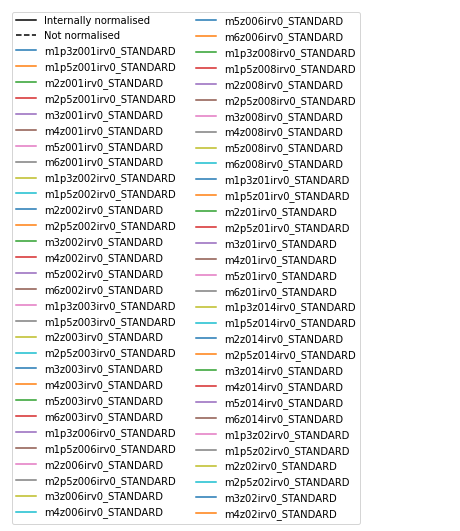

In [23]:
plot_legend(models1)

Now we can plot the models. This function will plot all possible isotope ratios against each other for the element in the internal normalisation ratio. As we have quite a few models we will first plot only the internally normalised data and then plot the unnormalised data in a seperate cell.

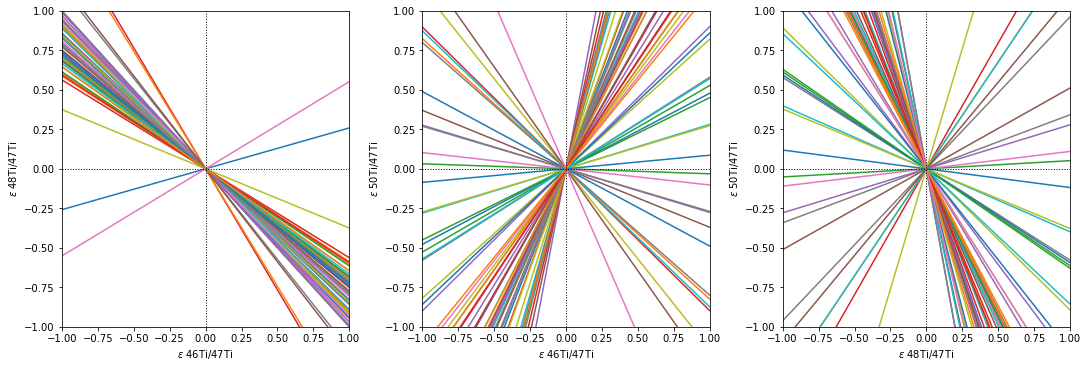

In [24]:
plot_models_all(models1, internal_normalisation_ratio1, plot_normalised=True, plot_unnormalised=False)

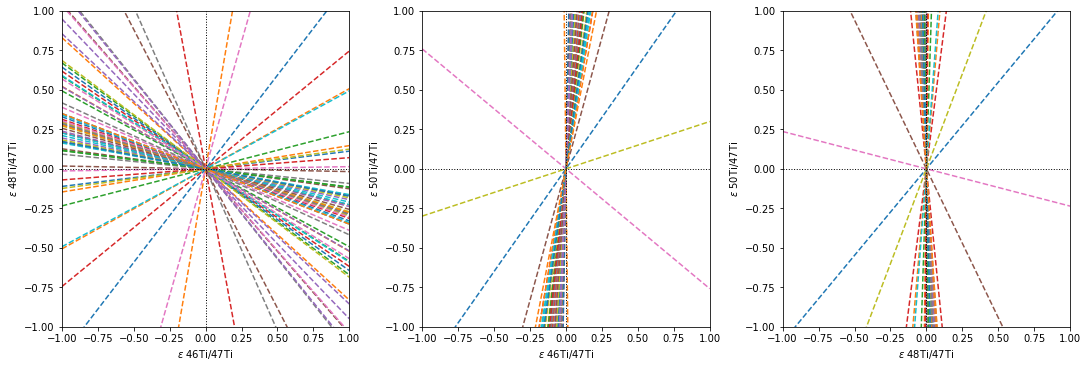

In [25]:
plot_models_all(models1, internal_normalisation_ratio1, plot_normalised=False, plot_unnormalised=True)

---

Here is a different normalisation for a different element and only including the models with a solar metallicity

In [40]:
internal_normalisation_ratio2 = '108Pd/105Pd'
models2 = filter_models('z014')

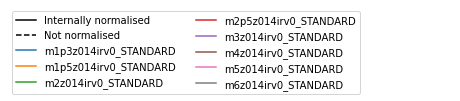

In [27]:
plot_legend(models2)

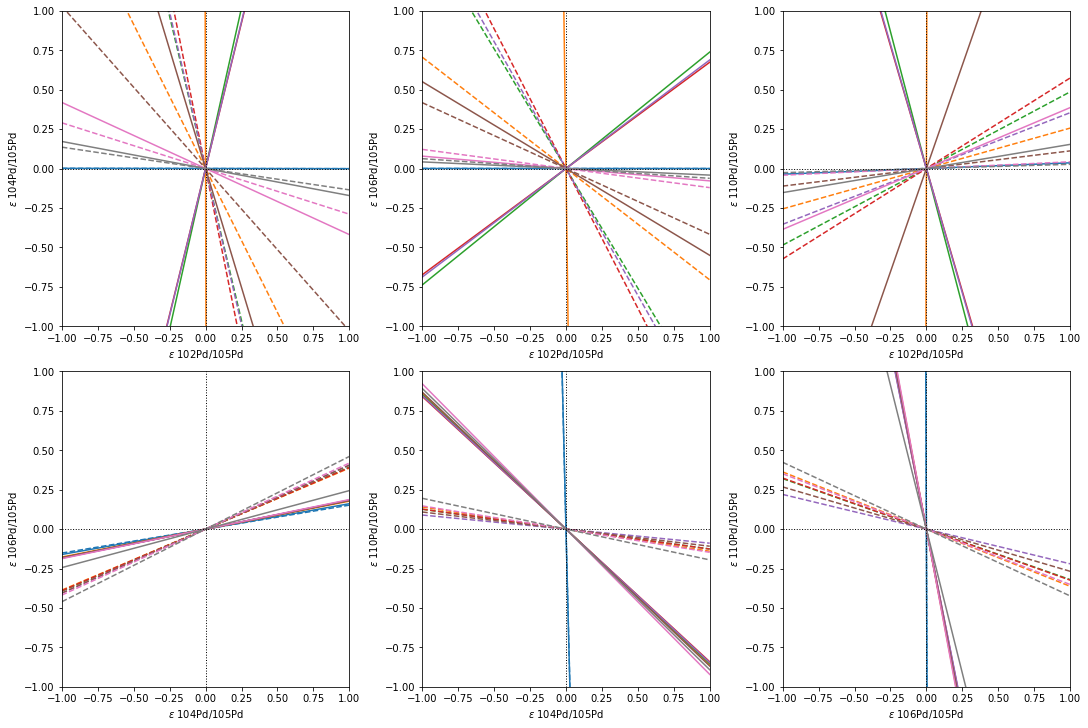

In [41]:
plot_models_all(models2, internal_normalisation_ratio2, plot_normalised=True, plot_unnormalised=True)

---
### plot_models_xy
Here we compare the isotopes normalised with different internal normalisation ratios.

In [42]:
x_isotope1 = '92mo'
x_internal_normalisation1 = '98mo/96mo'

y_isotope1 = '100ru'
y_internal_normalisation1 = '99ru/101ru'

xymodels1 = all_models

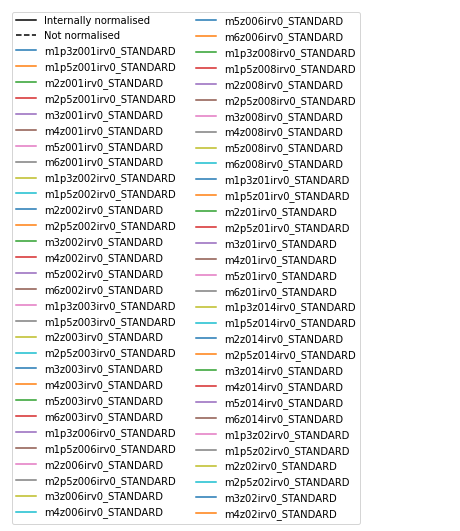

In [43]:
plot_legend(xymodels1)

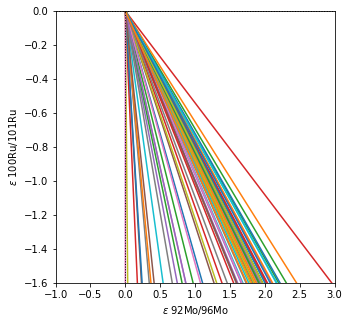

In [44]:
plot_models_xy(xymodels1, x_isotope1, y_isotope1,  x_internal_normalisation1, y_internal_normalisation1, 
               xlim=(-1, 3), ylim=(-1.6, 0), plot_normalised = True, plot_unnormalised=False)

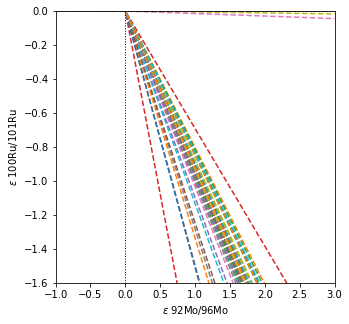

In [45]:
plot_models_xy(xymodels1, x_isotope1, y_isotope1,  x_internal_normalisation1, y_internal_normalisation1, 
               xlim=(-1, 3), ylim=(-1.6, 0), plot_normalised = False, plot_unnormalised=True)